In [1]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

### Análisis general de distintos modelos

In [ ]:
#pip install pycaret

In [2]:
import pycaret.classification

In [2]:
# De esta forma podemos realizar custom transformer
# Todas las transformaciones deberían tener su propio transformer

class SelectColumnsTransformer():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self

In [3]:
train_df = pd.read_csv("../data/travel_insurance_prediction_train.csv")
test_df = pd.read_csv("../data/travel_insurance_prediction_test.csv")

Explorar preliminarmente todos los modelos de clasificación posibles, para hacer un primer descarte. Tomando parámetros por default.

In [4]:
from pycaret.classification import *
clf = setup(data = train_df, target = 'TravelInsurance')

,Description,Value
0,session_id,7123
1,Target,TravelInsurance
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(1490, 10)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,7
8,Ordinal Features,False
9,High Cardinality Features,False


In [5]:
#best = compare_models()
best = compare_models(sort = 'F1') #default is 'Accuracy', LO CAMBIO POR F1 QUE ES LA INDICADA COMO REFERENCIA

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8042,0.8103,0.6278,0.8036,0.6984,0.5577,0.5713,0.1980
xgboost,Extreme Gradient Boosting,0.7965,0.8177,0.6463,0.7688,0.6978,0.5469,0.5547,0.3440
gbc,Gradient Boosting Classifier,0.8157,0.8115,0.5729,0.8850,0.6904,0.5696,0.5992,0.0710
catboost,CatBoost Classifier,0.8061,0.8086,0.5888,0.8449,0.6866,0.5539,0.5770,1.1230
rf,Random Forest Classifier,0.7840,0.7977,0.6413,0.7389,0.6833,0.5214,0.5269,0.2490
knn,K Neighbors Classifier,0.7918,0.7863,0.5627,0.8199,0.6621,0.5199,0.5423,0.0310
et,Extra Trees Classifier,0.7619,0.7690,0.6359,0.6916,0.6600,0.4780,0.4809,0.2060
dt,Decision Tree Classifier,0.7600,0.7393,0.6358,0.6911,0.6585,0.4746,0.4784,0.0180
ada,Ada Boost Classifier,0.7946,0.7837,0.5076,0.8927,0.6395,0.5126,0.5557,0.0700
lda,Linear Discriminant Analysis,0.7754,0.7754,0.5260,0.7927,0.6293,0.4786,0.5007,0.0730


In [6]:
#Crear un modelo para identificar la importancia de las variables
dt=create_model("dt")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7714,0.7661,0.7179,0.6829,0.7000,0.5156,0.5160
1,0.8095,0.8030,0.6667,0.7879,0.7222,0.5788,0.5835
2,0.7885,0.7741,0.7368,0.7000,0.7179,0.5489,0.5494
3,0.7308,0.7352,0.6053,0.6389,0.6216,0.4129,0.4133
4,0.7692,0.7498,0.6579,0.6944,0.6757,0.4968,0.4972
5,0.7404,0.7259,0.6316,0.6486,0.6400,0.4370,0.4371
6,0.7885,0.7618,0.7105,0.7105,0.7105,0.5439,0.5439
7,0.7596,0.7291,0.6579,0.6757,0.6667,0.4787,0.4789
8,0.7788,0.7135,0.5000,0.8261,0.6230,0.4795,0.5098
9,0.6635,0.6340,0.4737,0.5455,0.5070,0.2535,0.2549


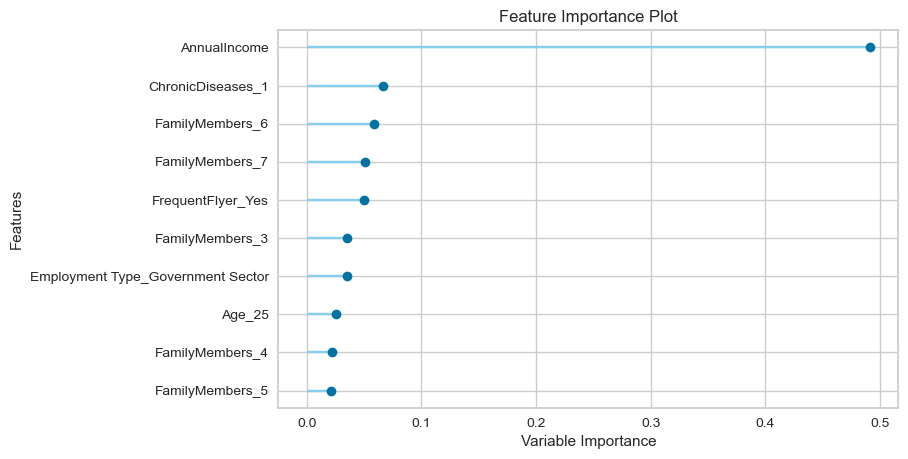

In [8]:
plot_model(dt, plot = 'feature')

In [10]:
#Crear un modelo para identificar la importancia de las variables
xgb=create_model("xgboost")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7905,0.8028,0.6923,0.7297,0.7105,0.5465,0.5470
1,0.8381,0.8497,0.7179,0.8235,0.7671,0.6439,0.6475
2,0.7596,0.8236,0.7105,0.6585,0.6835,0.4902,0.4911
3,0.7500,0.7781,0.6316,0.6667,0.6486,0.4548,0.4552
4,0.8269,0.8511,0.6053,0.8846,0.7188,0.6000,0.6225
5,0.8365,0.8046,0.7368,0.8000,0.7671,0.6415,0.6428
6,0.8077,0.8347,0.6842,0.7647,0.7222,0.5759,0.5779
7,0.8077,0.8142,0.6316,0.8000,0.7059,0.5659,0.5747
8,0.8077,0.8521,0.6053,0.8214,0.6970,0.5608,0.5748
9,0.7404,0.7659,0.4474,0.7391,0.5574,0.3890,0.4136


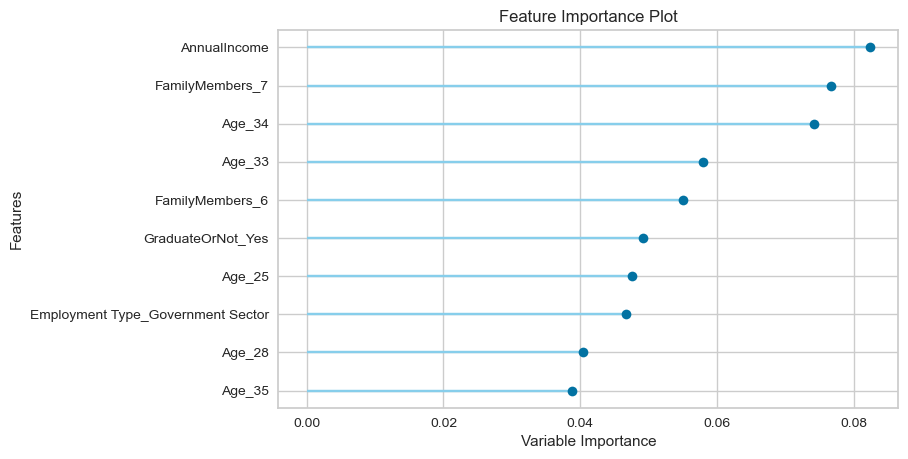

In [11]:
plot_model(xgb, plot = 'feature')

### Dividimos los datos en train y validation 

Para tener la posibilidad de evaluar los diferentes modelos en un conjunto de validación

In [12]:
# The data for training the models
X_train = train_df.drop(columns=["Customer", "TravelInsurance"])
y_train = train_df["TravelInsurance"].values

In [13]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [14]:
X_train_.shape, X_val.shape, y_train_.shape, y_val.shape

((1192, 8), (298, 8), (1192,), (298,))

**Repaso el modelo baseline**

Pero con la división de grupo de train reducido y validación, ahora.

In [21]:
#Pre-procesamiento transformaciones
transformer = make_column_transformer(
    (KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"), ["Age", "AnnualIncome"]),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"),
     ["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]),
    remainder="passthrough")

#Usó absolutamente todas las variables del dataset, "remainder="passthrough"" le indica que lo que no esté mencionado, pasa como está.

In [22]:
X_train_p=transformer.fit_transform(X_train_)   #aplico sobre todas las columnas 
X_val_p=transformer.transform(X_val)   

In [23]:
#Los parámetros del modelo baseline son
baseline_params={
    'criterion': 'entropy', 
    'max_depth': 10, 
    'min_samples_leaf': 5}

In [24]:
tree_baseline = DecisionTreeClassifier(criterion="entropy", max_depth= 10, min_samples_leaf= 5, random_state=42)
tree_baseline.fit(X_train_p, y_train_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [25]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train_, tree_baseline.predict(X_train_p)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, tree_baseline.predict(X_val_p)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       758
           1       0.89      0.64      0.74       434

    accuracy                           0.84      1192
   macro avg       0.85      0.80      0.81      1192
weighted avg       0.85      0.84      0.83      1192

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       200
           1       0.86      0.61      0.71        98

    accuracy                           0.84       298
   macro avg       0.85      0.78      0.80       298
weighted avg       0.84      0.84      0.83       298



### Otros modelos para analizar este problema de clasificación

In [26]:
#Pre-procesamiento con pipelines para hacer más sencillas las variantes (idem versión anterior)
variables_num=["Age", "AnnualIncome"]
variables_cat=["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad", "ChronicDiseases"]

Xtrain=X_train_[variables_num+variables_cat]
Xval=X_val[variables_num+variables_cat]

transf_num=Pipeline([('select_num_columns', SelectColumnsTransformer(variables_num)),
                    ('kbins_discretizer', KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"))      
                    ])

transf_cat=Pipeline([('select_cat_columns', SelectColumnsTransformer(variables_cat)),
                    ('one_hot_enc', OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"))      
                    ])

pipeline_transformer = ColumnTransformer([('num', transf_num, variables_num),
                                        ('cat', transf_cat, variables_cat)
                                        ])

train = pipeline_transformer.fit_transform(Xtrain)
val = pipeline_transformer.fit_transform(Xval)

In [42]:
#Todas las alternativas de pre-procesamiento con pipelines 

##1er paso: filtras qué variables vamos a considerar en el modelo
variables_num=["Age", "AnnualIncome"]
#variables_cat=["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad","ChronicDiseases"]
variables_cat=["Employment Type", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]

##reduce el dataset en función de las columnas seleccionadas
Xtrain=X_train_[variables_num+variables_cat]
Xval=X_val[variables_num+variables_cat]

##2do paso: programa las transformaciones según tipo de variable
transf_num=Pipeline([('select_num_columns', SelectColumnsTransformer(variables_num)),
                    ('kbins_discretizer', KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")),
                   #  ("standard_scaler", StandardScaler()),
                   #  ("min_max_scaler", MinMaxScaler())
                    ])

transf_cat=Pipeline([('select_cat_columns', SelectColumnsTransformer(variables_cat)),
                    ('one_hot_enc', OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"))      
                    ])

pipeline_transformer = ColumnTransformer([('num', transf_num, variables_num),
                                        ('cat', transf_cat, variables_cat)
                                        ])

##3er paso: ejecuta la transformación de manera conjunta
train = pipeline_transformer.fit_transform(Xtrain)
val = pipeline_transformer.fit_transform(Xval)

In [43]:
tree_baseline_ = DecisionTreeClassifier(criterion="entropy", max_depth= 10, min_samples_leaf= 5, random_state=42)
tree_baseline_.fit(train, y_train_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [44]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train_, tree_baseline_.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, tree_baseline_.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       758
           1       0.88      0.63      0.74       434

    accuracy                           0.84      1192
   macro avg       0.85      0.79      0.81      1192
weighted avg       0.84      0.84      0.83      1192

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       200
           1       0.77      0.51      0.61        98

    accuracy                           0.79       298
   macro avg       0.78      0.72      0.73       298
weighted avg       0.79      0.79      0.78       298



Eliminando del modelo dos variables que no serían muy necesarias, los resultados se mantienen relativamente iguales

**Modelo SGD**

El modelo SGD Clasifier requiere que los variables numéricas estén estandarizadas, modifico el pipeline numérico en función de eso.

In [37]:
#Todas las alternativas de pre-procesamiento con pipelines 

##1er paso: filtras qué variables vamos a considerar en el modelo
variables_num=["Age", "AnnualIncome"]
variables_cat=["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad","ChronicDiseases"]
#variables_cat=["Employment Type", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]

##reduce el dataset en función de las columnas seleccionadas
Xtrain=X_train_[variables_num+variables_cat]
Xval=X_val[variables_num+variables_cat]

##2do paso: programa las transformaciones según tipo de variable
transf_num=Pipeline([('select_num_columns', SelectColumnsTransformer(variables_num)),
                   # ('kbins_discretizer', KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")),
                     ("standard_scaler", StandardScaler()),
                   #  ("min_max_scaler", MinMaxScaler())
                    ])

transf_cat=Pipeline([('select_cat_columns', SelectColumnsTransformer(variables_cat)),
                    ('one_hot_enc', OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"))      
                    ])

pipeline_transformer = ColumnTransformer([('num', transf_num, variables_num),
                                        ('cat', transf_cat, variables_cat)
                                        ])

##3er paso: ejecuta la transformación de manera conjunta
train = pipeline_transformer.fit_transform(Xtrain)
val = pipeline_transformer.fit_transform(Xval)

In [40]:
#Entrenamiento de la versión más sencilla del modelo, con parámetros por default
sgd = SGDClassifier(random_state=42)
sgd.fit(train, y_train_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [41]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train_, sgd.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, sgd.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       774
           1       0.75      0.47      0.58       418

    accuracy                           0.76      1192
   macro avg       0.76      0.69      0.71      1192
weighted avg       0.76      0.76      0.74      1192

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.73      0.92      0.81       184
           1       0.77      0.44      0.56       114

    accuracy                           0.73       298
   macro avg       0.75      0.68      0.68       298
weighted avg       0.74      0.73      0.71       298



No pareciera estar ofreciendo mejores resultados que el Árbol de Decisión. Vamos a probar optimizando los hiperparámetros, haciendo un GridSearchCV.

In [62]:
#Grilla de parámetros
params={'loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
        'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'penalty':['l1','l2','elasticnet'],
      # 'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive']
       }

sgd_= SGDClassifier(random_state=42)

In [63]:
#Búsqueda de parámetros
cv_sgd = GridSearchCV(sgd_, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
cv_sgd.fit(train, y_train_)

GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'log', 'modified_huber',
                                  'squared_hinge', 'perceptron'],
     

In [64]:
cv_sgd.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
cv_sgd.best_params_

{'alpha': 0.001, 'loss': 'log', 'penalty': 'elasticnet'}

In [66]:
#Entrenamiento de la mejor versión encontrada del modelo
sgd = SGDClassifier(random_state=42,alpha=0.001, loss='log', penalty='elasticnet' )
sgd.fit(train, y_train_)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [67]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train_, sgd.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, sgd.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       774
           1       0.80      0.46      0.59       418

    accuracy                           0.77      1192
   macro avg       0.78      0.70      0.71      1192
weighted avg       0.77      0.77      0.75      1192

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       184
           1       0.85      0.45      0.59       114

    accuracy                           0.76       298
   macro avg       0.79      0.70      0.71       298
weighted avg       0.78      0.76      0.74       298



La mejor opción de este modelo, encontrada por medio del GridSearchCV mejora las predicciones sobre el conjunto de validación en relación al modelo con parámetros por default pero continúa sin ser una mejor alternativa que el Árbol de Decisión.

**Modelo Random Forest Classifier**

Voy a hacer el primer entrenamiento de este modelo, en su versión más simple, con las variables preprocesadas del mismo modo que en el modelo tomado como baseline

In [48]:
#Todas las alternativas de pre-procesamiento con pipelines 

##1er paso: filtras qué variables vamos a considerar en el modelo
#variables_num=["Age", "AnnualIncome"]
variables_num=["Age", "AnnualIncome", "FamilyMembers"]
#variables_cat=["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad","ChronicDiseases"]
variables_cat=["Employment Type", "GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad","ChronicDiseases"]
#variables_cat=["Employment Type", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]

##reduce el dataset en función de las columnas seleccionadas
Xtrain=X_train_[variables_num+variables_cat]
Xval=X_val[variables_num+variables_cat]

##2do paso: programa las transformaciones según tipo de variable
transf_num=Pipeline([('select_num_columns', SelectColumnsTransformer(variables_num)),
                    ('kbins_discretizer', KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")),
                   #  ("standard_scaler", StandardScaler()),
                   #  ("min_max_scaler", MinMaxScaler())
                    ])

transf_cat=Pipeline([('select_cat_columns', SelectColumnsTransformer(variables_cat)),
                    ('one_hot_enc', OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"))      
                    ])

pipeline_transformer = ColumnTransformer([('num', transf_num, variables_num),
                                        ('cat', transf_cat, variables_cat)
                                        ])

##3er paso: ejecuta la transformación de manera conjunta
train = pipeline_transformer.fit_transform(Xtrain)
val = pipeline_transformer.fit_transform(Xval)

In [49]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(train, y_train_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [50]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train_, rfc.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, rfc.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.85      0.94      0.90       758
           1       0.88      0.71      0.79       434

    accuracy                           0.86      1192
   macro avg       0.87      0.83      0.84      1192
weighted avg       0.86      0.86      0.86      1192

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       200
           1       0.68      0.58      0.63        98

    accuracy                           0.77       298
   macro avg       0.74      0.72      0.73       298
weighted avg       0.77      0.77      0.77       298



 Vamos a probar optimizando los hiperparámetros, haciendo un GridSearchCV.

In [51]:
#Grilla de parámetros
params={'n_estimators':[4, 6, 8 , 10 , 12],
        'criterion':['gini','entropy'],
        'max_depth':[6, 8, 10, 12],
        'min_samples_leaf':[2, 4, 5, 8],
       }

rfc_= RandomForestClassifier(random_state=42)

In [52]:
#Búsqueda de parámetros
cv_rfc = GridSearchCV(rfc_, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
cv_rfc.fit(train, y_train_)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [53]:
cv_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [54]:
cv_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 5,
 'n_estimators': 10}

In [55]:
#Entrenamiento de la mejor versión encontrada del modelo
rfc = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth= 8, min_samples_leaf= 5, random_state=42)
rfc.fit(train, y_train_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [56]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train_, rfc.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, rfc.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.79      0.96      0.86       758
           1       0.88      0.56      0.68       434

    accuracy                           0.81      1192
   macro avg       0.83      0.76      0.77      1192
weighted avg       0.82      0.81      0.80      1192

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       200
           1       0.84      0.52      0.64        98

    accuracy                           0.81       298
   macro avg       0.82      0.74      0.76       298
weighted avg       0.81      0.81      0.79       298



**Modelo XGBOOST**

In [80]:
#Todas las alternativas de pre-procesamiento con pipelines 

##1er paso: filtras qué variables vamos a considerar en el modelo
variables_num=["Age", "AnnualIncome", "FamilyMembers"]
variables_cat=["Employment Type", "GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad","ChronicDiseases"]
#variables_cat=["Employment Type", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]

##reduce el dataset en función de las columnas seleccionadas
Xtrain=X_train_[variables_num+variables_cat]
Xval=X_val[variables_num+variables_cat]

##2do paso: programa las transformaciones según tipo de variable
transf_num=Pipeline([('select_num_columns', SelectColumnsTransformer(variables_num)),
                    ('kbins_discretizer', KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")),
                   #  ("standard_scaler", StandardScaler()),
                   #  ("min_max_scaler", MinMaxScaler())
                    ])

transf_cat=Pipeline([('select_cat_columns', SelectColumnsTransformer(variables_cat)),
                    ('one_hot_enc', OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"))      
                    ])

pipeline_transformer = ColumnTransformer([('num', transf_num, variables_num),
                                        ('cat', transf_cat, variables_cat)
                                        ])

##3er paso: ejecuta la transformación de manera conjunta
train = pipeline_transformer.fit_transform(Xtrain)
val = pipeline_transformer.transform(Xval)

In [60]:
import xgboost as xgb

In [61]:
xg = xgb.XGBClassifier(seed=42)
xg.fit(train, y_train_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [62]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train_, xg.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, xg.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       758
           1       0.90      0.69      0.78       434

    accuracy                           0.86      1192
   macro avg       0.87      0.82      0.84      1192
weighted avg       0.86      0.86      0.85      1192

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.80      0.88      0.83       200
           1       0.68      0.54      0.60        98

    accuracy                           0.77       298
   macro avg       0.74      0.71      0.72       298
weighted avg       0.76      0.77      0.76       298



Vamos a probar optimizando los hiperparámetros, haciendo un GridSearchCV.

In [63]:
#Grilla de parámetros
params={'objective':["reg:squarederror", "reg:squaredlogerror", "reg:logistic" , "reg:pseudohubererror" , "binary:logistic","binary:hinge"],
        'learning_rate':[0.05, 0.1,0.2,0.3],
        'max_depth':[2,4,5, 6, 7, 8, 9],
        'alpha':[2, 3, 5, 7, 8, 10],
        "n_estimators":[5, 7, 10]
       }

xg_= xgb.XGBClassifier(seed=42)

In [64]:
#Búsqueda de parámetros
cv_xg = GridSearchCV(xg_, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
cv_xg.fit(train, y_train_)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [2, 3, 5, 7, 8, 10],
                         'learning_rate': [0.05, 0.1, 0.2, 0.3],
                         'max_depth': [2, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [5, 7, 10],
       

In [65]:
cv_xg.best_estimator_

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=7, n_jobs=4, num_parallel_tree=1,
              objective='binary:hinge', random_state=42, reg_alpha=5,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [66]:
cv_xg.best_params_

{'alpha': 5,
 'learning_rate': 0.3,
 'max_depth': 4,
 'n_estimators': 7,
 'objective': 'binary:hinge'}

In [69]:
#Entrenamiento de la mejor versión encontrada del modelo
xg = xgb.XGBClassifier(alpha=5, learning_rate=0.3, max_depth=4, objective='binary:hinge', n_estimators=7 ,seed=42)
xg.fit(train, y_train_)

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=7, n_jobs=4, num_parallel_tree=1,
              objective='binary:hinge', random_state=42, reg_alpha=5,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [70]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train_, xg.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, xg.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       758
           1       0.83      0.61      0.70       434

    accuracy                           0.81      1192
   macro avg       0.82      0.77      0.78      1192
weighted avg       0.81      0.81      0.80      1192

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       200
           1       0.79      0.65      0.72        98

    accuracy                           0.83       298
   macro avg       0.82      0.78      0.80       298
weighted avg       0.83      0.83      0.82       298



In [71]:
#Entrenamiento de la otra especificación
xg = xgb.XGBClassifier(alpha=3, learning_rate=0.3, max_depth=6, objective='binary:hinge', n_estimators=7 ,seed=42)
xg.fit(train, y_train_)

XGBClassifier(alpha=3, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=7, n_jobs=4, num_parallel_tree=1,
              objective='binary:hinge', random_state=42, reg_alpha=3,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [72]:
print("MÉTRICAS CONJUNTO DE TRAIN")
print(classification_report(y_train_, xg.predict(train)))
print("MÉTRICAS CONJUNTO DE VALIDACIÓN")
print(classification_report(y_val, xg.predict(val)))

MÉTRICAS CONJUNTO DE TRAIN
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       758
           1       0.85      0.61      0.71       434

    accuracy                           0.82      1192
   macro avg       0.83      0.77      0.79      1192
weighted avg       0.82      0.82      0.81      1192

MÉTRICAS CONJUNTO DE VALIDACIÓN
              precision    recall  f1-score   support

           0       0.84      0.94      0.88       200
           1       0.83      0.63      0.72        98

    accuracy                           0.84       298
   macro avg       0.83      0.78      0.80       298
weighted avg       0.83      0.84      0.83       298



Este modelo encontrado da un mejor resultado que los previamente analizados.

### Para hacer una submission

In [81]:
# The test data is only for generating the submission
X_test = pipeline_transformer.transform(test_df.drop(columns=["Customer"]))

In [83]:
test_id = test_df["Customer"]
test_pred = xg.predict(X_test)

submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["Customer", "TravelInsurance"])
submission.to_csv("../data/travel_insurance_submission_flo1.csv", header=True, index=False)